# 2D RCM with Emanuel convection

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import climlab
from climlab import constants as const

In [2]:
# A two-dimensional domain
fullstate = climlab.column_state(num_lev=30, num_lat=30, water_depth=10.)
# Try starting with a specified relative humidity distribution
h2o = climlab.radiation.ManabeWaterVapor(state=fullstate)
#  Add specific_humidity to the state dictionary
fullstate['q'] = h2o.q
# Temperatue state
tempstate = {'Tatm':fullstate.Tatm,'Ts':fullstate.Ts}
#  The top-level model
model = climlab.TimeDependentProcess(state=fullstate, name='Radiative-Convective-Diffusive Model',
                                    timestep=const.seconds_per_hour)
#  Convection scheme -- water vapor is a state variable
conv = climlab.convection.EmanuelConvection(state=fullstate,
                              timestep=const.seconds_per_hour)
#  Insolation as a function of latitude and time of year
sun = climlab.radiation.AnnualMeanInsolation(domains=model.Ts.domain)
#  Couple the radiation to insolation and water vapor processes
rad = climlab.radiation.RRTMG(state=tempstate, 
                              specific_humidity=fullstate.q, 
                              albedo=0.125,
                              insolation=sun.insolation,
                              coszen=sun.coszen,
                              timestep=const.seconds_per_day)
model.add_subprocess('Radiation', rad)
model.add_subprocess('Insolation', sun)
model.add_subprocess('Convection', conv)

In [3]:
from climlab.dynamics import MeridionalDiffusion

# thermal diffusivity in W/m**2/degC
D = 0.04
# meridional diffusivity in m**2/s
K = D / model.Tatm.domain.heat_capacity[0] * const.a**2
d = MeridionalDiffusion(state=tempstate, 
                        K=K, **model.param)
#model.add_subprocess('Diffusion', d)

In [4]:
#  Add surface heat fluxes
shf = climlab.surface.SensibleHeatFlux(state=tempstate, Cd=0.5E-3)
lhf = climlab.surface.LatentHeatFlux(state=tempstate, Cd=0.5E-3)
# set the water vapor input field for LHF
lhf.q = fullstate.q
model.add_subprocess('SHF', shf)
model.add_subprocess('LHF', lhf)

In [5]:
print( model)

climlab Process of type <class 'climlab.process.time_dependent_process.TimeDependentProcess'>. 
State variables and domain shapes: 
  Ts: (30, 1) 
  Tatm: (30, 30) 
  q: (30, 30) 
The subprocess tree: 
Radiative-Convective-Diffusive Model: <class 'climlab.process.time_dependent_process.TimeDependentProcess'>
   Radiation: <class 'climlab.radiation.rrtm.rrtmg.RRTMG'>
      SW: <class 'climlab.radiation.rrtm.rrtmg_sw.RRTMG_SW'>
      LW: <class 'climlab.radiation.rrtm.rrtmg_lw.RRTMG_LW'>
   Insolation: <class 'climlab.radiation.insolation.AnnualMeanInsolation'>
   Convection: <class 'climlab.convection.emanuel_convection.EmanuelConvection'>
   SHF: <class 'climlab.surface.turbulent.SensibleHeatFlux'>
   LHF: <class 'climlab.surface.turbulent.LatentHeatFlux'>



In [6]:
model.integrate_years(4.)
model.integrate_years(1.)

Integrating for 35063 steps, 1460.9688 days, or 4.0 years.
Total elapsed time is 3.999971343217611 years.
Integrating for 8765 steps, 365.2422 days, or 1.0 years.
Total elapsed time is 4.999878619359299 years.


Text(0.5, 1.0, 'Relative humidity')

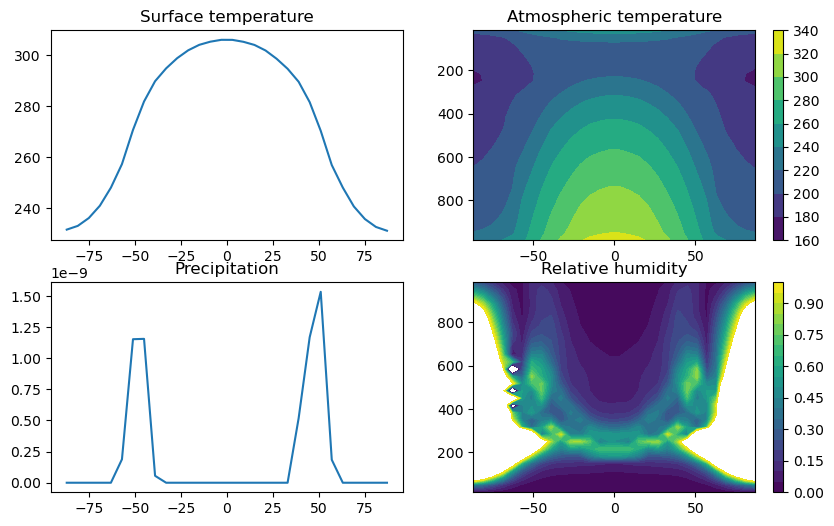

In [7]:
fig, ax = plt.subplots(2,2,figsize=(10,6))
ax[0,0].plot(model.lat, model.timeave['Ts'])
ax[0,0].set_title('Surface temperature')
cax = ax[0,1].contourf(model.lat, model.lev, model.timeave['Tatm'].transpose())
ax[0,1].invert_yaxis()
fig.colorbar(cax)
ax[0,1].set_title('Atmospheric temperature')
ax[1,0].plot(model.lat, model.timeave['precipitation'])
ax[1,0].set_title('Precipitation')
cax = ax[1,1].contourf(model.lat, model.lev, model.timeave['relative_humidity'].transpose(), levels=np.arange(0,1.05,0.05))
fig.colorbar(cax)
ax[1,1].set_title('Relative humidity')